## Análisis de los lagos

In [ ]:
#!pip install openeo
#!pip install rasterio
#!pip install sentinelhub

### 1) Establecer conexión con API Sentinel 2

In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from datetime import date
import openeo

# Conexión al backend que opera sobre Sentinel Hub (Copernicus)
connection = openeo.connect("https://openeo.sentinel-hub.com/production/").authenticate_oidc()

### 2) Descargar imagenes .tif usando las coordenadas

In [ ]:
coords_atitlan = {
    "west": -91.326256, 
    "south": 14.5948, 
    "east": -91.07151, 
    "north": 14.750979
    }

coords_amatitlan = {
    "west": -90.638065, 
    "south": 14.412347, 
    "east": -90.512924, 
    "north": 14.493799
    }

### 3) Seleccionar periodo de observación 

In [ ]:
cube_atitlan = connection.load_collection(
    "SENTINEL2_L2A",
    spatial_extent=coords_atitlan, #region de Guatemala
    temporal_extent=["2024-01-01", "2024-06-30"],
    bands=["B04","B05","B06","B08","B11","B12"]  # incluye bandas necesarias para cianobacterias
)

cube_amatitlan = connection.load_collection(
    "SENTINEL2_L2A",
    spatial_extent=coords_amatitlan,
    temporal_extent=["2024-01-01", "2024-06-30"],
    bands=["B04","B05","B06","B08","B11","B12"]
)

### 4) Aplicar el script de detección de cianobacterias 

Todo este proceso se realizó en el browser de Sentinel 2 y se descargaron las imagenes en la carpeta "img"

### 6) Convertir los .tif a arreglos numpy

In [ ]:
import os
import numpy as np
import rasterio
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from scipy.signal import find_peaks

carpeta_tif = "."
resultados = []

# --- Leer imágenes ---
for archivo in os.listdir(carpeta_tif):
    if archivo.lower().endswith((".tif", ".tiff")):
        ruta = os.path.join(carpeta_tif, archivo)
        with rasterio.open(ruta) as src:
            img = src.read(1).astype(float)
            nodata = src.nodata
            if nodata is not None:
                img = np.where(img == nodata, np.nan, img)
            promedio = np.nanmean(img)

        # Extraer nombre y fecha
        nombre_sin_ext = archivo.rsplit(".", 1)[0]
        for i, c in enumerate(nombre_sin_ext):
            if c.isdigit():
                lago = nombre_sin_ext[:i]
                fecha_str = nombre_sin_ext[i:]
                break
        fecha = datetime.strptime(fecha_str, "%Y-%m-%d")

        resultados.append({
            "Lago": lago.capitalize(),
            "Fecha": fecha,
            "Promedio": promedio
        })

# --- Crear DataFrame ---
df = pd.DataFrame(resultados).sort_values(by=["Lago", "Fecha"])


### Indice promedio, evolución temporal y posibles picos de floración de la cianobacteria

In [ ]:
# --- Detectar picos relativos ---
picos_lista = []
plt.figure(figsize=(10, 6))

for lago, datos in df.groupby("Lago"):
    datos = datos.sort_values("Fecha")
    fechas = datos["Fecha"].to_numpy()
    valores = datos["Promedio"].to_numpy()

    # Detectar picos
    idx_picos, _ = find_peaks(valores)
    picos_fecha = fechas[idx_picos]
    picos_valor = valores[idx_picos]

    # Guardar picos detectados
    for f, v in zip(picos_fecha, picos_valor):
        picos_lista.append({"Lago": lago, "Fecha": f, "Promedio": v})

    # Graficar línea
    plt.plot(fechas, valores, marker="o", label=lago)
    # Marcar picos
    plt.scatter(picos_fecha, picos_valor, color="red", zorder=5)

plt.xlabel("Fecha")
plt.ylabel("Índice promedio de cianobacteria")
plt.title("Evolución temporal y picos detectados")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Mostrar tabla de picos ---
picos_df = pd.DataFrame(picos_lista)
print("\nPicos de floración detectados:")
print(picos_df)

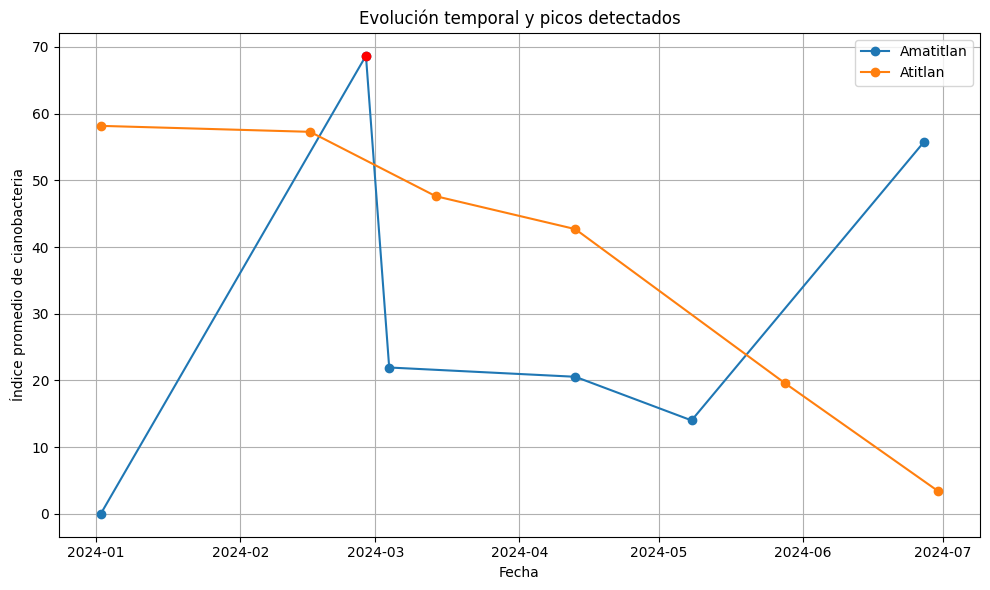
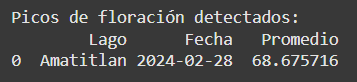

En la gráfica se puede observar que el indice promedio de la cianobacteria en amatitlan comienza muy bajo en enero de 2024, sube hacia marzo con un máximo de 69 aproximadamente y luego baja y vuelve a subir en junio menor que el anterior. Mientras que en el Labo de Atitlán, el indice empezó alto con un valor de 58 aproximadamente, después se mantiene hasta en el periodo de marzo-abril que empieza a descender constantemente hasta llegar a valores muy bajos en julio, aproximadamente de 3. Para atitlán, no se detectaron picos extremos, pero si se pueden observar máximos locales claros.

In [ ]:

import os
import re
from datetime import datetime
import numpy as np
import pandas as pd
import rasterio
import matplotlib.pyplot as plt
import folium
from folium.raster_layers import ImageOverlay
from PIL import Image

CARPETA_TIF = "img" 
CARPETA_FIGS = "./figs"
CARPETA_MAPS = "./maps"
os.makedirs(CARPETA_FIGS, exist_ok=True)
os.makedirs(CARPETA_MAPS, exist_ok=True)


In [ ]:

re_fecha = r"(19|20)\d{2}[-_]\d{2}[-_]\d{2}"
re_indice = r"(NDVI|NDWI)"
pat = re.compile(
    rf"""^(?P<lago>[A-Za-zÀ-ÿ0-9]+?)(?:[-_])?(?:(?P<indice>{re_indice})[-_])?(?P<fecha>{re_fecha})\.tiff?$""",
    re.IGNORECASE | re.VERBOSE
)

def normaliza_fecha(s):
    s = s.replace("_", "-")
    return datetime.strptime(s, "%Y-%m-%d")

def parsear_nombre(archivo):
    m = pat.match(archivo)
    if not m:
        return None
    lago = m.group("lago")
    indice = m.group("indice")
    fecha = normaliza_fecha(m.group("fecha"))
    tipo = "CYANO"
    if indice:
        indice_up = indice.upper()
        if indice_up == "NDVI":
            tipo = "NDVI"
        elif indice_up == "NDWI":
            tipo = "NDWI"
    return {"lago": lago.capitalize(), "fecha": fecha, "tipo": tipo}

def leer_raster(ruta):
    with rasterio.open(ruta) as src:
        arr = src.read(1).astype("float32")
        if src.nodata is not None:
            arr = np.where(arr == src.nodata, np.nan, arr)
        return arr, src.transform, src.crs, src.bounds

def resumen_array(arr):
    return {
        "mean": float(np.nanmean(arr)),
        "std": float(np.nanstd(arr)),
        "min": float(np.nanmin(arr)),
        "max": float(np.nanmax(arr)),
        "count": int(np.count_nonzero(~np.isnan(arr))),
    }

inventario = []
for archivo in os.listdir(CARPETA_TIF):
    if not archivo.lower().endswith((".tif", ".tiff")):
        continue
    meta = parsear_nombre(archivo)
    if not meta:
        continue
    inventario.append({**meta, "archivo": archivo, "ruta": os.path.join(CARPETA_TIF, archivo)})

inv_df = pd.DataFrame(inventario).sort_values(["lago", "fecha", "tipo"])
display(inv_df)

metricas = []
rasters_cache = {}
for _, fila in inv_df.iterrows():
    arr, transform, crs, bounds = leer_raster(fila["ruta"])
    rasters_cache[(fila["lago"], fila["fecha"], fila["tipo"])] = (arr, transform, crs, bounds)
    metricas.append({
        "Lago": fila["lago"],
        "Fecha": fila["fecha"],
        "Tipo": fila["tipo"],
        **resumen_array(arr)
    })

metricas_df = pd.DataFrame(metricas).sort_values(["Lago", "Fecha", "Tipo"])
display(metricas_df)


,lago,fecha,tipo,archivo,ruta
0,Amatitlan,2024-01-02,CYANO,amatitlan2024-01-02.tiff,img\amatitlan2024-01-02.tiff
1,Amatitlan,2024-02-28,CYANO,amatitlan2024-02-28.tiff,img\amatitlan2024-02-28.tiff
2,Amatitlan,2024-03-04,CYANO,amatitlan2024-03-04.tiff,img\amatitlan2024-03-04.tiff
3,Amatitlan,2024-04-13,CYANO,amatitlan2024-04-13.tiff,img\amatitlan2024-04-13.tiff
4,Amatitlan,2024-05-08,CYANO,amatitlan2024-05-08.tiff,img\amatitlan2024-05-08.tiff
5,Amatitlan,2024-06-27,CYANO,amatitlan2024-06-27.tiff,img\amatitlan2024-06-27.tiff
6,Atitlan,2024-01-02,CYANO,atitlan2024-01-02.tiff,img\atitlan2024-01-02.tiff
7,Atitlan,2024-02-16,CYANO,atitlan2024-02-16.tiff,img\atitlan2024-02-16.tiff
8,Atitlan,2024-03-14,CYANO,atitlan2024-03-14.tiff,img\atitlan2024-03-14.tiff
9,Atitlan,2024-04-13,CYANO,atitlan2024-04-13.tiff,img\atitlan2024-04-13.tiff


,Lago,Fecha,Tipo,mean,std,min,max,count
0,Amatitlan,2024-01-02,CYANO,0.000000,0.000000,0.0,0.0,742500
1,Amatitlan,2024-02-28,CYANO,68.675720,38.165932,0.0,255.0,742500
2,Amatitlan,2024-03-04,CYANO,21.936069,33.453926,0.0,255.0,742500
3,Amatitlan,2024-04-13,CYANO,20.545490,22.855165,0.0,178.0,742500
4,Amatitlan,2024-05-08,CYANO,14.004596,25.260046,0.0,255.0,742500
5,Amatitlan,2024-06-27,CYANO,55.789734,34.691181,0.0,171.0,742500
6,Atitlan,2024-01-02,CYANO,58.162598,64.335106,0.0,255.0,742500
7,Atitlan,2024-02-16,CYANO,57.267868,61.281567,0.0,255.0,742500
8,Atitlan,2024-03-14,CYANO,47.620411,39.871304,0.0,255.0,742500
9,Atitlan,2024-04-13,CYANO,42.684162,31.326138,0.0,255.0,742500



=== Amatitlan ===


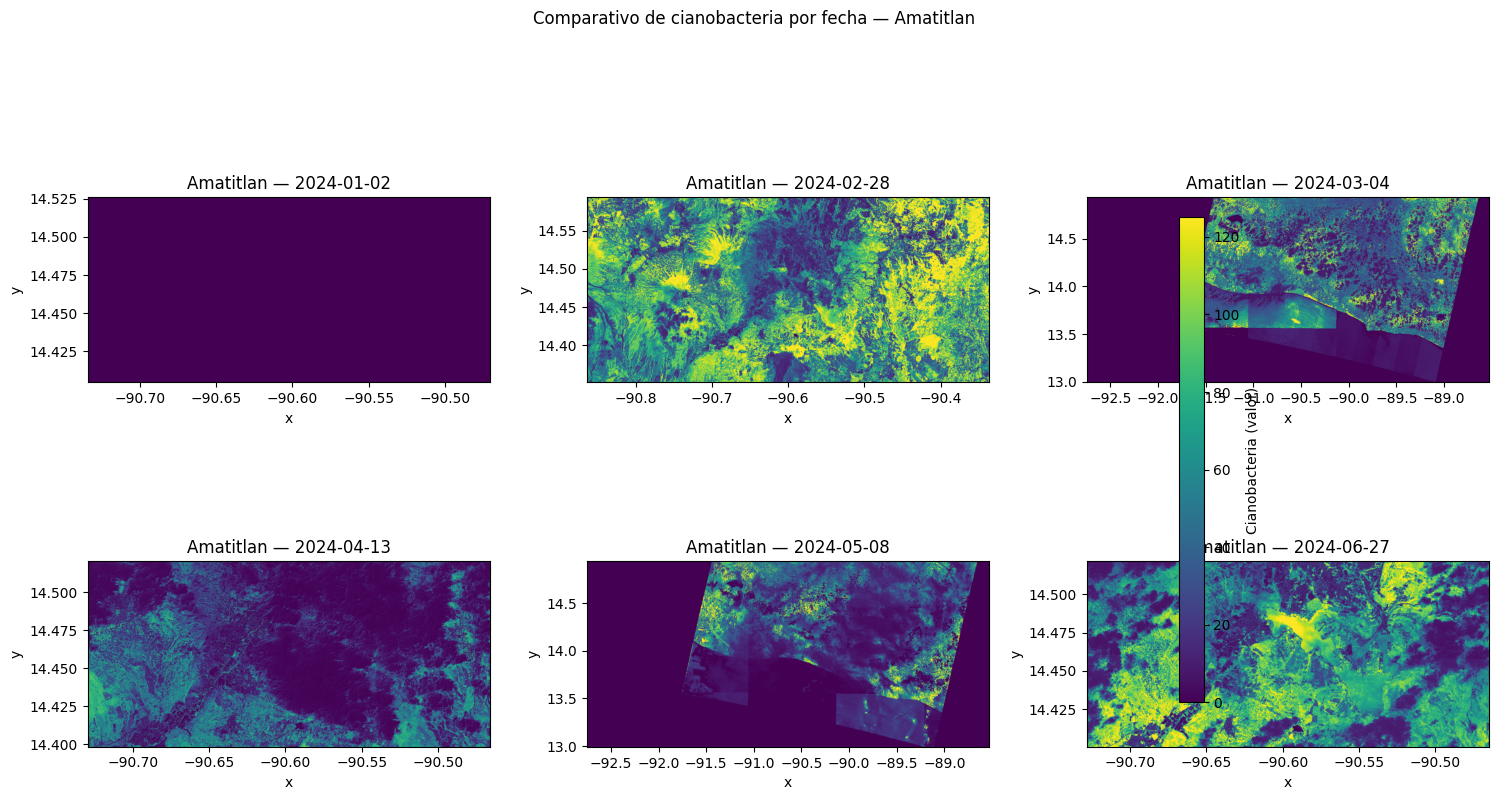

[OK] Panel comparativo guardado: ./figs\ComparativoPanel_Amatitlan.png
[OK] Mapa folium comparativo guardado: ./maps\Comparativo_Amatitlan.html

=== Atitlan ===


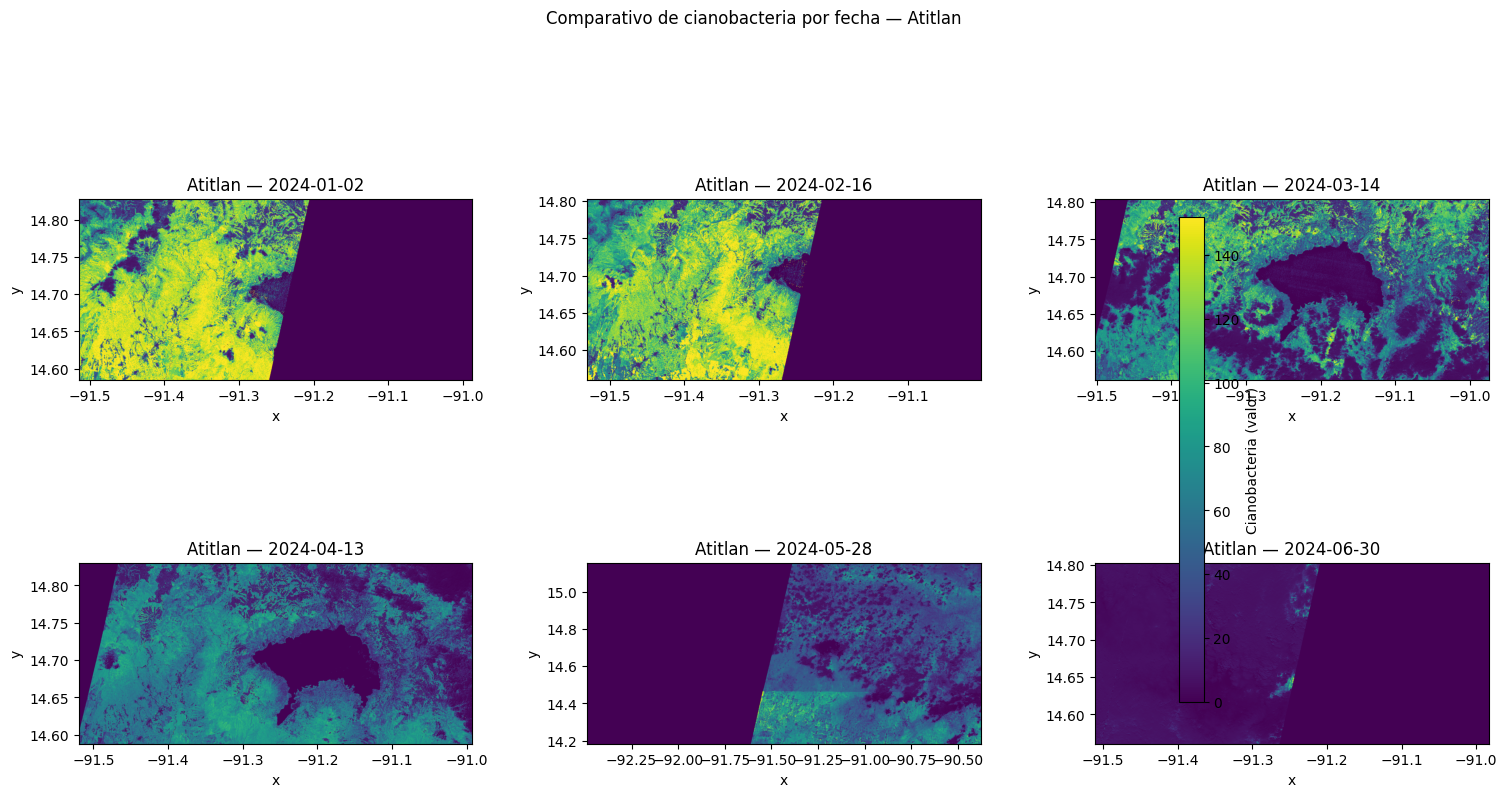

[OK] Panel comparativo guardado: ./figs\ComparativoPanel_Atitlan.png
[OK] Mapa folium comparativo guardado: ./maps\Comparativo_Atitlan.html


In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
import folium
from folium.raster_layers import ImageOverlay
from PIL import Image
import os

CARPETA_FIGS = CARPETA_FIGS if 'CARPETA_FIGS' in globals() else "./figs"
CARPETA_MAPS = CARPETA_MAPS if 'CARPETA_MAPS' in globals() else "./maps"
os.makedirs(CARPETA_FIGS, exist_ok=True)
os.makedirs(CARPETA_MAPS, exist_ok=True)

def extent_from_transform(transform, arr_shape):
    
    xmin = transform.c
    ymax = transform.f
    xmax = xmin + transform.a * arr_shape[1]
    ymin = ymax + transform.e * arr_shape[0]
    return [xmin, xmax, ymin, ymax]

def normaliza_para_png(arr):
    a = np.array(arr, dtype="float32")
    vmin = np.nanpercentile(a, 2)
    vmax = np.nanpercentile(a, 98)
    if np.isfinite(vmin) and np.isfinite(vmax) and vmax > vmin:
        a = (a - vmin) / (vmax - vmin)
    else:
        a = np.zeros_like(a)
    a = np.clip(a, 0, 1)
    rgba = np.zeros((a.shape[0], a.shape[1], 4), dtype="float32")
    rgba[..., 0] = a
    rgba[..., 1] = a
    rgba[..., 2] = a
    rgba[..., 3] = np.where(np.isnan(arr), 0.0, 0.9)
    return (rgba * 255).astype("uint8")

def comparativo_matplotlib_por_lago(lago, entradas, max_cols=3):
    if len(entradas) == 0:
        print(f"[{lago}] No hay rasters CYANO para comparar.")
        return
    entradas = sorted(entradas, key=lambda t: t[0])
    stack_vals = np.concatenate([e[1].ravel() for e in entradas])
    stack_vals = stack_vals[np.isfinite(stack_vals)]
    if stack_vals.size >= 10:
        vmin = np.percentile(stack_vals, 2)
        vmax = np.percentile(stack_vals, 98)
    else:
        vmin, vmax = np.nanmin(stack_vals), np.nanmax(stack_vals)
    if not np.isfinite(vmin) or not np.isfinite(vmax) or vmin == vmax:
        vmin, vmax = 0.0, 1.0

    n = len(entradas)
    cols = min(max_cols, n)
    rows = math.ceil(n / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4.5*rows), squeeze=False)
    axes = axes.ravel()

    for i, (fecha, arr, transform, bounds) in enumerate(entradas):
        ax = axes[i]
        extent = extent_from_transform(transform, arr.shape)
        im = ax.imshow(arr, extent=extent, vmin=vmin, vmax=vmax)
        ax.set_title(f"{lago} — {fecha.date()}")
        ax.set_xlabel("x")
        ax.set_ylabel("y")

    for j in range(i+1, rows*cols):
        axes[j].axis("off")

    cbar = fig.colorbar(im, ax=axes[:n], shrink=0.7)
    cbar.set_label("Cianobacteria (valor)")

    fig.suptitle(f"Comparativo de cianobacteria por fecha — {lago}", y=0.995)
    fig.tight_layout()
    out_path = os.path.join(CARPETA_FIGS, f"ComparativoPanel_{lago}.png")
    fig.savefig(out_path, dpi=150)
    plt.show()
    print(f"[OK] Panel comparativo guardado: {out_path}")

def comparativo_folium_por_lago(lago, entradas):

    if len(entradas) == 0:
        return
    _, _, _, first_bounds = entradas[0]
    lat_c = (first_bounds.top + first_bounds.bottom) / 2
    lon_c = (first_bounds.left + first_bounds.right) / 2
    m = folium.Map(location=[lat_c, lon_c], zoom_start=11, control_scale=True, tiles="CartoDB positron")

    for (fecha, arr, transform, bounds) in sorted(entradas, key=lambda t: t[0]):

        png_path = os.path.join(CARPETA_MAPS, f"{lago}_CYANO_{fecha.date()}.png")
        Image.fromarray(normaliza_para_png(arr)).save(png_path)
        layer_name = f"{fecha.date()}"
        try:
            ImageOverlay(
                name=layer_name,
                image=png_path,
                bounds=[[bounds.bottom, bounds.left], [bounds.top, bounds.right]],
                opacity=0.7,
                interactive=True,
                cross_origin=False,
                zindex=1,
            ).add_to(m)
        except Exception as e:
            print(f"[Aviso] No se pudo añadir overlay {lago} {fecha.date()}: {e}")

    folium.LayerControl(collapsed=False).add_to(m)
    out_html = os.path.join(CARPETA_MAPS, f"Comparativo_{lago}.html")
    m.save(out_html)
    print(f"[OK] Mapa folium comparativo guardado: {out_html}")

if 'rasters_cache' not in globals() or len(rasters_cache) == 0:
    print("No hay rasters en 'rasters_cache'. Asegúrate de haber corrido las celdas de lectura primero.")
else:
    lagos = sorted({k[0] for k in rasters_cache.keys()})
    for lago in lagos:
        entradas = []
        for (L, fecha, tipo), (arr, transform, crs, bounds) in rasters_cache.items():
            if L == lago and tipo == "CYANO":
                entradas.append((fecha, arr, transform, bounds))

        print(f"\n=== {lago} ===")
        comparativo_matplotlib_por_lago(lago, entradas, max_cols=3)
        comparativo_folium_por_lago(lago, entradas)


### 9.1) Análisis de la proliferación de la cianobacteria en el periodo estudiado para cada lado

Los resultados de la gráfica que muestra la evolución temporal y los picos detectados para el Lago de Amatitlán, indican que la floración de la cianobacteria fue intensa pero poco frecuente, concentrada en un solo evento principal. En el caso de Atitlán, no se observa un poco tan pronunciado como en Amatitlán, sino una tendencia descendente continua, esto sugiere una floración más prolongada pero menos variable.

### 9.2) Comparación de Intensidad y frecuencia de floraciones en ambos lagos

En cuanto a intensidad, el lago de Amatitlán presentó una mayor en febrero que se ve representado por el pico más alto, el cual supera cualquier valor de Atitlán. En cuanto a frecuencia, Amatitlán tuvo una sola floración intensa en febrero, mientras que Atitlán mantuvo niveles altos por más tiempo, sin un pico tan marcado pero con una presencia más constante en el primer trimestre.

### 9.3) Posibles diferencias entre las causas de la proliferación de la cianobacteria

- Geografía: Amatitlán es un lago más pequeño y menos profundo que Atitlán, por lo que se calienta más rápido y puede generar floraciones rápidas y puntuales.

- Uso del suelo y presión urbana: Amatitlán está rodeado por zonas altamente urbanizadas e industriales (Ciudad de Guatemala y Villa Nueva), lo que aporta grandes cantidades de nutrientes (nitrogeno y fósforo) de manera repentina con las lluvias o descargas. Atitlán, aunque también recibe presión urbana y agrícola, tiene una cuenca más extensa y un intercambio de agua distinto.

- Temperatura y clima: El clima alrededor de Amatitlán es más cálido y menos ventoso, lo que beneficia la estratificación térmica y floraciones rápidas. Mientras que Atitlán, al estar en un área más alta, tiene temperaturas más frescas y viento más frecuente, lo que podría dispersar las floraciones.

- Hidrodinámica: Atitlán tiene mayor volumen de agua y mezcla vertical, lo que puede diluir la concentración de cianobacterias, pero si las condiciones son favorables, la floración puede mantenerse más estable.

### Referencias

Carmichael, W. W. (2008). A world overview—One-hundred-twenty-seven years of research on toxic cyanobacteria—Where do we go from here? Environmental Toxicology, 23(2), 220–230. https://doi.org/10.1002/tox.20249

Chorus, I., & Bartram, J. (Eds.). (1999). Toxic cyanobacteria in water: A guide to their public health consequences, monitoring and management. World Health Organization. https://apps.who.int/iris/handle/10665/42827

Pinto, M., & Roldán, G. (2016). Eutrofización y floraciones de cianobacterias: Procesos y manejo. Revista de Ciencias Ambientales, 50(1), 35–49. https://doi.org/10.15359/rca.50-1.3

Díaz-Valbuena, L. R., Pérez, J. A., & Ramírez, D. C. (2018). Factores ambientales asociados a la proliferación de cianobacterias en cuerpos de agua. Revista Facultad de Ciencias Básicas, 14(1), 50–65. https://doi.org/10.18359/rfcb.2929